In [96]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import quantstats as qs

import matplotlib.pyplot as plt

In [97]:
# Downloading Dow Jones index data from Yahoo Finance
dji = yf.download('^DJI', start='2003-01-01', end='2023-01-01')

# Extracting the closing prices
close_prices = dji['Close']

[*********************100%%**********************]  1 of 1 completed


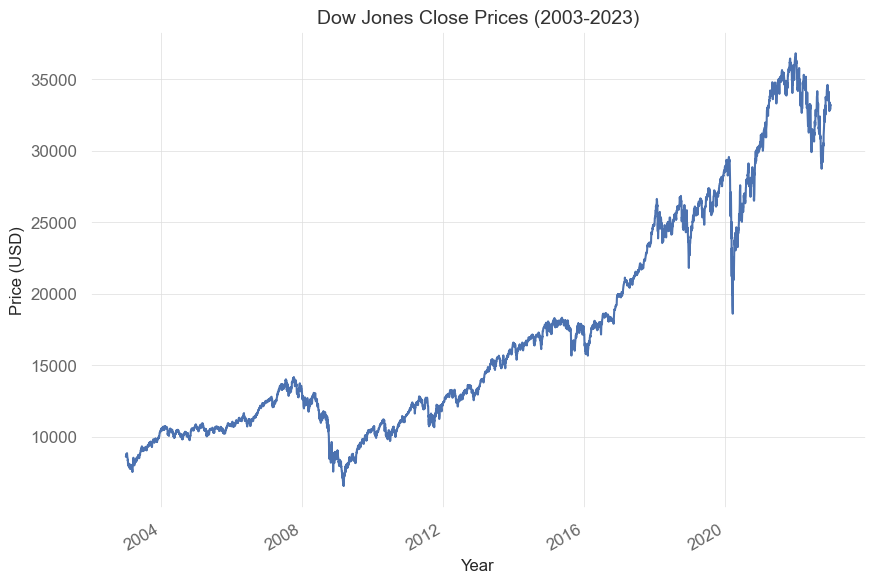

In [98]:
# Plotting the Dow Jones closing prices
close_prices.plot(figsize=(10, 7), linewidth=1.5)
plt.title('Dow Jones Close Prices (2003-2023)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True)
plt.show()

## Developing Robust Indicators

In [99]:
# Calculating Moving Averages (Indicators)
short_window = 50
long_window = 252

short_ma = close_prices.rolling(window=short_window, min_periods=short_window).mean()
long_ma = close_prices.rolling(window=long_window, min_periods=long_window).mean()

## Crafting Effective Trade Signals

In [100]:
# Generating Trading Signals
signals = pd.DataFrame(index=close_prices.index)
signals['signal'] = 0.0  # Set the default to be 0
signals['short_ma'] = short_ma
signals['long_ma'] = long_ma

In [101]:
# When the short is above the long, buy - else go short sell.
# Note that our signal is just a simple buy or sell, -1 or 1.
signals['signal'][signals['short_ma'] > signals['long_ma']] = 1
signals['signal'][signals['short_ma'] < signals['long_ma']] = -1

## Calculate Daily Returns for the Strategy

In [102]:
# Calculate daily percentage returns of DJI
dji_returns = close_prices.pct_change()

In [103]:
# Calculate strategy returns by multiplying DJI returns with the lagged signals
strategy_returns = dji_returns * signals['signal'].shift(1)

## Position Sizing

In [104]:
# Set the target volatility level
tgt_vol = 0.15

# Calculate the rolling annual standard deviation of DJI returns
signals['stdev'] = dji_returns.rolling(22).std() * np.sqrt(252)  # Convert to annualized standard deviation

# Calculate volatility target weights
signals['vol_tgt'] = tgt_vol / signals['stdev']

# Clip weights to a maximum of 1 to avoid leverage
# Here we use 2x leverage to make sure we can hit our volatility target of 15%
signals['vol_tgt'] = signals['vol_tgt'].clip(0, 2)

In [105]:
# Adjust the signal by the volatility target, lagging both to avoid look-ahead bias
vol_signal = signals['signal'].shift(1) * signals['vol_tgt'].shift(1)

# Compute returns for the volatility-targeted strategy
strategy_voltgt_returns = dji_returns * vol_signal

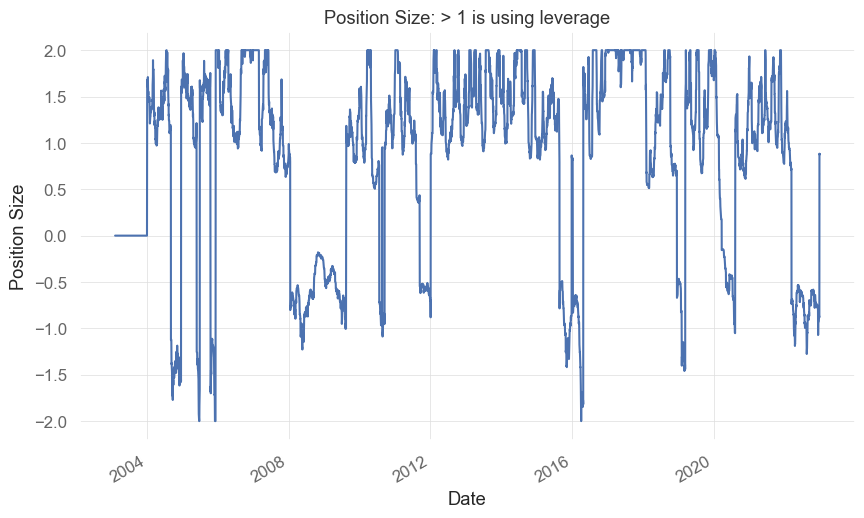

In [106]:
# Plot the position sizes to see how much leverage is being used.
vol_signal.plot()
plt.title('Position Size: > 1 is using leverage')
plt.ylabel('Position Size')
plt.show()